In [1]:
# Basic packagess
import pandas as pd
import numpy as np
from scipy import stats 
# Results visualization
import matplotlib.pyplot as plt
import seaborn as sns
# lifelines
from lifelines.datasets import load_waltons
from lifelines import CoxPHFitter,KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, RobustScaler

def confidence_interval(stats,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
    
hugo_predictors = [
    "original_firstorder_Energy",
    "original_shape_Compactness",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity",
    "original_shape_Volume"]

hugo_outcome = ["deadstatus.event","Survival.time"]

df1_radiomics= pd.read_csv('./data/raw_GTV-1_only.csv')

df1_clinical = pd.read_csv('./data/Lung1.clinical_Updated_Len.csv')
df1_merge = df1_radiomics.merge(df1_clinical,on = "patient_id")
df1_merge['original_shape_Sphericity'] = df1_merge['original_shape_Sphericity'] **3
df1_merge = df1_merge.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
# dflung1 = df1_merge[hugo_used]
df1_merge = df1_merge.rename(index=str,columns={'Updated.Survival.time':'Survival.time'})
df1_merge = df1_merge.rename(index=str,columns={'Updated.deadstatus.event':'deadstatus.event'})
dflung1 = df1_merge[hugo_predictors + hugo_outcome]

dflung2 = pd.read_csv('./data/Lung2.clinical_radiomics_GTV_ZW.csv')
dflung2['original_shape_Sphericity'] = dflung2['original_shape_Sphericity'] **3
dflung2 = dflung2.rename(index=str,columns={'original_shape_Sphericity':'original_shape_Compactness'})
dflung2 = dflung2[hugo_predictors + hugo_outcome]

In [2]:
dflung1[hugo_predictors] = np.log10(dflung1[hugo_predictors])
dflung2[hugo_predictors] = np.log10(dflung2[hugo_predictors])

# pre-processing
# all features are normalized by using z-score normalization
dflung1_f = dflung1[hugo_predictors]
dflung2_f = dflung2[hugo_predictors]


dflung2[hugo_predictors] = (dflung2[hugo_predictors] - dflung2_f.mean(axis=0)) / (dflung2_f.std(axis=0, ddof=0))
# dflung2[hugo_predictors] = (dflung2[hugo_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))
dflung1[hugo_predictors] = (dflung1[hugo_predictors] - dflung1_f.mean(axis=0)) / (dflung1_f.std(axis=0, ddof=0))

C:\Users\zhenwei.shi\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [3]:
# box_predictors = [
#     "Energy",
#     "Compactness",
#     "GLN",
#     "wavelet-GLN",
#     "Volume"
#     ]
# dflung1_box = dflung1[hugo_predictors]
# dflung2_box = dflung2[hugo_predictors]
# data1 = pd.DataFrame(columns= ['Feature','Value','Cohort'])
# data2 = pd.DataFrame(columns= ['Feature','Value','Cohort'])
# feature1 = pd.Series()
# value1 = pd.Series()
# feature2 = pd.Series()
# value2 = pd.Series()

# for i in range(dflung1_box.shape[0]):
#     feature1 = feature1.append(pd.Series(box_predictors))
#     value1 = value1.append(dflung1_box.iloc[i,:])
# for i in range(dflung2_box.shape[0]):
#     feature2 = feature2.append(pd.Series(box_predictors))
#     value2 = value2.append(dflung2_box.iloc[i,:])

# data1['Feature'] = feature1
# data1['Value'] = value1.values[:]
# data1['Cohort'] = 'Lung1'
# data2['Feature'] = feature2
# data2['Value'] = value2.values[:]
# data2['Cohort'] = 'Lung2'

# data = pd.concat([data1,data2])
# plt.figure(figsize=(15,10))
# ax = sns.boxplot(x = 'Feature',y = 'Value',hue = 'Cohort', data = data)
# plt.ylim(-5,20)
# # plt.savefig('./DLR_result/NonLog_BoxPlot.pdf')
# # plt.savefig('./DLR_result/Log_BoxPlot.pdf')
# plt.show()

In [4]:
alpha = 0.95
for i in range(np.shape(hugo_predictors)[0]):
    cox1 = CoxPHFitter()
    cox1.fit(dflung1[[hugo_predictors[i]]+['Survival.time','deadstatus.event']],duration_col='Survival.time', event_col='deadstatus.event')
#     cox1.print_summary() # access the results using cph.summary
    n_bs = 100 # bootstrap 100 times 
    C_index = []
    for j in range(n_bs):
        dflung2_bs = dflung2.sample(n_bs,replace=True)
        dflung2_feature = dflung2_bs[hugo_predictors].iloc[:,i]
        estimated_time = cox1.predict_expectation(pd.DataFrame(data = dflung2_feature)) # estimated survival time
        C_index2_bs = concordance_index(dflung2_bs['Survival.time'],estimated_time,dflung2_bs['deadstatus.event'])
        C_index.append(C_index2_bs)
    
    # scipy.stats Wilcoxon test,  two-sided p-value for the test
    T, p_wilcoxon = stats.wilcoxon(C_index,np.ones(n_bs)*0.5)
    print('Single featue: %s' %hugo_predictors[i])
    print(p_wilcoxon)
    print(np.mean(C_index))
    confidence_interval(C_index,alpha)
#     dflung2_feature = dflung2[hugo_predictors].iloc[:,i]
#     estimated_time = cox1.predict_expectation(pd.DataFrame(data = dflung2_feature))
#     C_index2 = concordance_index(dflung2['Survival.time'],estimated_time,dflung2['deadstatus.event'])
#     print(C_index2)

Single featue: original_firstorder_Energy
2.4829640944730308e-14
0.5366271947864114
95.0 confidence interval 47.7% and 60.4%
Single featue: original_shape_Compactness
2.0478704108103747e-08
0.5214599910645412
95.0 confidence interval 45.5% and 58.9%
Single featue: original_glrlm_GrayLevelNonUniformity
3.896559845095909e-18
0.596472495065893
95.0 confidence interval 54.5% and 65.1%
Single featue: wavelet-HLH_glrlm_GrayLevelNonUniformity
3.896559845095909e-18
0.5887935970539722
95.0 confidence interval 51.4% and 66.3%
Single featue: original_shape_Volume
3.896559845095909e-18
0.5865545623113868
95.0 confidence interval 53.2% and 65.4%


In [6]:
for i in range(np.shape(hugo_predictors)[0]):
    lung1_feature = dflung1[hugo_predictors].iloc[:,i]
    lung2_feature = dflung2[hugo_predictors].iloc[:,i]
    sep_median_lung1 = np.median(lung1_feature)
    dflung1_high = dflung1[lung1_feature <= sep_median_lung1]
    dflung1_low =dflung1[lung1_feature > sep_median_lung1]
    dflung2_high = dflung2[lung2_feature <= sep_median_lung1]
    dflung2_low =dflung2[lung2_feature > sep_median_lung1]
    
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(11,10))
#     plt.xlim(0,1500)
    plt.xlabel("Survival time (days)", {"fontsize": 20})
    plt.ylabel("Survival probability", {"fontsize": 20})
    plt.title("Kaplan_Meier radiomics signature", {"fontsize": 20, "fontweight": "bold"})
    
    kmf.fit(dflung1_high["Survival.time"], event_observed=dflung1_high["deadstatus.event"])
    plt.plot(kmf.survival_function_, "k+-",drawstyle='steps')

    kmf.fit(dflung2_high["Survival.time"], event_observed=dflung2_high["deadstatus.event"])
    plt.plot(kmf.survival_function_, "r+-",drawstyle='steps')

    kmf.fit(dflung1_low["Survival.time"], event_observed=dflung1_low["deadstatus.event"])
    plt.plot(kmf.survival_function_, "k+--",drawstyle='steps')

    kmf.fit(dflung2_low["Survival.time"], event_observed=dflung2_low["deadstatus.event"])
    plt.plot(kmf.survival_function_, "r+--",drawstyle='steps')

#     first_legend = plt.legend(["Lung1 > Median", "Lung2 > Median", "Lung1 <= Median", "Lung2 <= Median"])

#     ax = plt.gca().add_artist(first_legend)
#     plt.legend(["Maastro: Lung1", "Radboud: Lung2"], loc=3)
#     plt.savefig('./DLR_result/DLR_KM_Nonlog_feature_%s.pdf' % i)
    plt.savefig('./DLR_result/DLR_KMfull_log_feature_%s.pdf' % i)
    results_1 = logrank_test(dflung1_low["Survival.time"], dflung1_high["Survival.time"],event_observed_A=dflung1_low["deadstatus.event"], event_observed_B=dflung1_high["deadstatus.event"])
    results_2 = logrank_test(dflung2_low["Survival.time"], dflung2_high["Survival.time"], event_observed_A=dflung2_low["deadstatus.event"], event_observed_B=dflung2_high["deadstatus.event"])
    print('Single Feature %s ------------------' %hugo_predictors[i])
    results_1.print_summary()
    results_2.print_summary()
    print('--------------------------------')
# plt.show()

Single Feature original_firstorder_Energy ------------------

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p    
        7.8490 0.0051  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.1182 0.7310
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
--------------------------------
Single Feature original_shape_Compactness ------------------

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.5263 0.4681
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.2438 0.6215
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
--------------------------------
Single Feature original_glrlm_GrayLevelNonUniformity ------------------

df=1, alpha=0.95, t_0=-1, null_distributio

In [22]:
cox1 = CoxPHFitter()
cox1.fit(dflung1.dropna(axis=0), duration_col='Survival.time', event_col='deadstatus.event')
cox1.print_summary() # access the results using cph.summary
# Wilcoxon test 
n_bs = 100 # bootstrap 100 times 
C_index = []
for i in range(n_bs):
    dflung2_bs = dflung2.sample(n_bs,replace=True)
    dflung2_4f = dflung2_bs.drop(['Survival.time','deadstatus.event'],axis=1)
#     hazard2 = cox1.predict_partial_hazard(dflung2_4f)
    estimated_time = cox1.predict_expectation(dflung2_4f) # estimated survival time
    C_index2_bs = concordance_index(dflung2_bs['Survival.time'],estimated_time,dflung2_bs['deadstatus.event'])
    C_index.append(C_index2_bs)
    
# scipy.stats Wilcoxon test,  two-sided p-value for the test
T, p_wilcoxon = stats.wilcoxon(C_index,np.ones(n_bs)*0.5)
print(p_wilcoxon)
print(np.mean(C_index))
# with volume
# pi_lung1 = cox1.summary.coef[0]*dflung1[hugo_predictors[0]] + cox1.summary.coef[1]*dflung1[hugo_predictors[1]] + cox1.summary.coef[2]*dflung1[hugo_predictors[2]]+ cox1.summary.coef[3]*dflung1[hugo_predictors[3]]+ cox1.summary.coef[4]*dflung1[hugo_predictors[4]]
# pi_lung2 = cox1.summary.coef[0]*dflung2[hugo_predictors[0]] + cox1.summary.coef[1]*dflung2[hugo_predictors[1]] + cox1.summary.coef[2]*dflung2[hugo_predictors[2]]+ cox1.summary.coef[3]*dflung2[hugo_predictors[3]]+ cox1.summary.coef[4]*dflung2[hugo_predictors[4]]

pi_lung1 = np.sum(cox1.summary.coef*dflung1[hugo_predictors],axis=1)
pi_lung2 = np.sum(cox1.summary.coef*dflung2[hugo_predictors],axis=1)
sep_median_lung1 = np.median(pi_lung1)
dflung1_high = dflung1[pi_lung1 <= sep_median_lung1]
dflung1_low =dflung1[pi_lung1 > sep_median_lung1]

# pi_lung2 = cox1.summary.coef[0]*dflung2[hugo_predictors[0]] + cox1.summary.coef[1]*dflung2[hugo_predictors[1]] + cox1.summary.coef[2]*dflung2[hugo_predictors[2]]+ cox1.summary.coef[3]*dflung2[hugo_predictors[3]]+ cox1.summary.coef[4]*dflung2[hugo_predictors[4]]
dflung2_high = dflung2[pi_lung2 <= sep_median_lung1]
dflung2_low =dflung2[pi_lung2 > sep_median_lung1]
print(sep_median_lung1)

n=421, number of events=374

                                            coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
original_firstorder_Energy                0.1432     1.1540    0.1588  0.9021 0.3670     -0.1679      0.4544   
original_shape_Compactness               -0.0188     0.9814    0.0580 -0.3242 0.7458     -0.1325      0.0949   
original_glrlm_GrayLevelNonUniformity     0.2864     1.3316    0.5144  0.5568 0.5777     -0.7217      1.2945   
wavelet-HLH_glrlm_GrayLevelNonUniformity  0.3890     1.4755    0.6262  0.6212 0.5344     -0.8383      1.6163   
original_shape_Volume                    -0.5865     0.5563    0.7911 -0.7414 0.4585     -2.1371      0.9641   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.583
Likelihood ratio test = 13.979 on 5 df, p=0.01574
4.531861061109546e-18
0.5649580237813501
0.03150977620714013


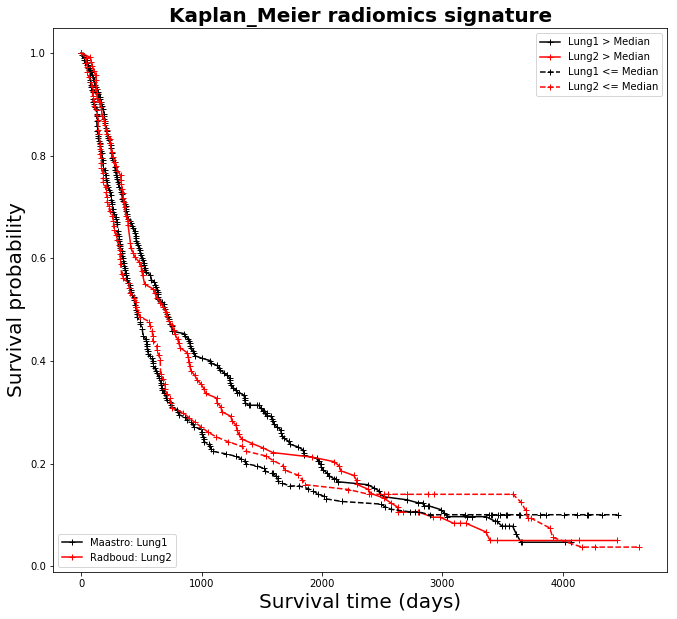

In [23]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(11,10))
# plt.xlim(0,1500)
plt.xlabel("Survival time (days)", {"fontsize": 20})
plt.ylabel("Survival probability", {"fontsize": 20})
plt.title("Kaplan_Meier radiomics signature", {"fontsize": 20, "fontweight": "bold"})
kmf.fit(dflung1_high["Survival.time"], event_observed=dflung1_high["deadstatus.event"])
plt.plot(kmf.survival_function_, "k+-")

# kmf.fit(dflung2_high["SurvTime_highrisk"], event_observed=dflung2_high["DeathStatus_highrisk"])
kmf.fit(dflung2_high["Survival.time"], event_observed=dflung2_high["deadstatus.event"])

plt.plot(kmf.survival_function_, "r+-")

kmf.fit(dflung1_low["Survival.time"], event_observed=dflung1_low["deadstatus.event"])
plt.plot(kmf.survival_function_, "k+--")

# kmf.fit(dflung2_low["SurvTime_lowrisk"], event_observed=dflung2_low["DeathStatus_lowrisk"])
kmf.fit(dflung2_low["Survival.time"], event_observed=dflung2_low["deadstatus.event"])

plt.plot(kmf.survival_function_, "r+--")

first_legend = plt.legend(["Lung1 > Median", "Lung2 > Median", "Lung1 <= Median", "Lung2 <= Median"])

ax = plt.gca().add_artist(first_legend)
plt.legend(["Maastro: Lung1", "Radboud: Lung2"], loc=3)
# plt.savefig('./DLR_result/DLR_KM_Nonlog_5features.pdf')
plt.savefig('./DLR_result/DLR_KM_log_5features.pdf')
plt.show()

In [24]:
results_1 = logrank_test(dflung1_low["Survival.time"], dflung1_high["Survival.time"], event_observed_A=dflung1_low["deadstatus.event"], event_observed_B=dflung1_high["deadstatus.event"])
results_2 = logrank_test(dflung2_low["Survival.time"], dflung2_high["Survival.time"], event_observed_A=dflung2_low["deadstatus.event"], event_observed_B=dflung2_high["deadstatus.event"])
print('Five Features ------------------')
results_1.print_summary()
results_2.print_summary()
print('--------------------------------')

Five Features ------------------

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        4.9698 0.0258  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

df=1, alpha=0.95, t_0=-1, null_distribution=chi squared

test_statistic      p   
        0.6707 0.4128
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
--------------------------------
